# Detecting spam text messages
----

The aim of this Natural Language Processing project is to predict whether a text message is spam or legitimate. We take the following steps:
- preprocessing: 
    - making text lowercase
    - removing punctuation
    - removing stop-words
    - stemming words
- new features generation
- bag-of-words approach comparison: CountVectorizer vs. TfidfVectorizer
- classifiers: Logistic Regression, Multinomial Naive Bayes, Support Vector Classifier
- final model optimisation

The dataset we use is from the UCI Machine Learning Repository and is [available here](https://www.kaggle.com/uciml/sms-spam-collection-dataset). It is a collection of 5,572 text messages tagged legitimate (0) or spam (1).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from nltk.corpus import stopwords
stopwords= stopwords.words("english")
from nltk.stem.porter import PorterStemmer
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [2]:
# loading the dataset
df= pd.read_csv("SMS_spam.csv")
df.head(8)

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0


A quick look at the above dataframe suggests that the classes are imbalanced. Let's visualise the number of spam vs. non-spam texts.

Spam texts:  0.13406317300789664


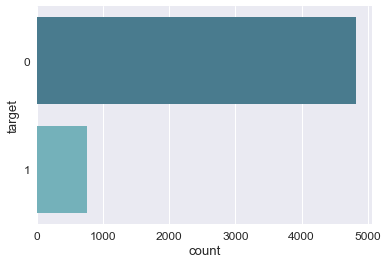

In [3]:
# visualising the number of genuine (0) vs. spam texts (1)
sns.set(font_scale=1.2)
sns.countplot(y="target", data=df, palette="GnBu_d")
print("Spam texts: ", len(df[df["target"]==1])/len(df))

The classes are indeed imbalanced: only 13.4% of texts are spam messages. For this reason, accuracy is not an appropriate metric to evaluate the performance of our models. A Dummy Classifier that always predicts the most frequent class would indeed be about 86% accurate. 

Instead, we will compute the Area Under the Receiver Operating Characteristic Curve (ROC AUC) score.

----
## Preprocessing
Text preprocessing is an important part of Natural Language Processing tasks. Let's start by making all letters lowercase and getting rid of punctuation.

In [4]:
# cleaning texts
def text_cleaning(df):
    text= df["text"]
    # making lowercase
    text= str.lower(text)
    # removing punctuation
    word_list= re.findall('[\w]+', text)
    return " ".join(word_list)

df["text"]= df.apply(text_cleaning, axis=1)
df.head()

,text,target
0,go until jurong point crazy available only in ...,0
1,ok lar joking wif u oni,0
2,free entry in 2 a wkly comp to win fa cup fina...,1
3,u dun say so early hor u c already then say,0
4,nah i don t think he goes to usf he lives arou...,0


Another typical preprocessing task is to remove very common words that do not carry much information, called stop-words. We can simply use the list of stop-words that we have imported from NLTK earlier.

In [5]:
# removing stopwords
def remove_stopwords(df):
    text= df["text"]
    words=[]
    for w in text.split():
        if w not in stopwords:
            words.append(w)
    return " ".join(words)

df["text"]= df.apply(remove_stopwords, axis=1)
df.head()

,text,target
0,go jurong point crazy available bugis n great ...,0
1,ok lar joking wif u oni,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1
3,u dun say early hor u c already say,0
4,nah think goes usf lives around though,0


Finally, let's use the PorterStemmer from NLTK to only keep the stem of the words in each text message.

In [6]:
# stemming words with PorterStemmer
def stem(df):
    stemmer= PorterStemmer()
    text= df["text"]
    words=[]
    for w in text.split():
        words.append(stemmer.stem(w))
    return " ".join(words)

df["text"]= df.apply(stem, axis=1)
df.head()

,text,target
0,go jurong point crazi avail bugi n great world...,0
1,ok lar joke wif u oni,0
2,free entri 2 wkli comp win fa cup final tkt 21...,1
3,u dun say earli hor u c alreadi say,0
4,nah think goe usf live around though,0


----
## Feature generation from text messages
Extracting new features from the text messages that we have can improve model performance. First, let's have a look at the length of spam/non-spam text messages.

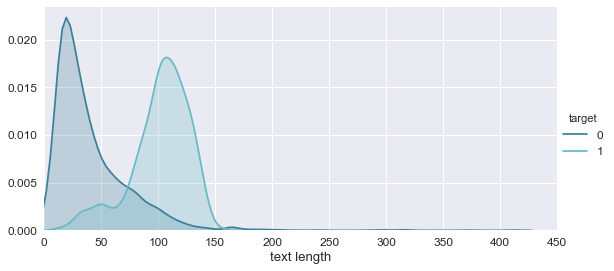

In [7]:
# calculating the length of each text message
def get_length(df):
    return len(df["text"])

df["text length"]= df.apply(get_length, axis=1)

# visualising text length for both classes
sns.set(font_scale=1.2)
fig= sns.FacetGrid(df, hue="target", size=4, aspect=2, palette="GnBu_d")
fig.map(sns.kdeplot, "text length", shade=True)
fig.set(xlim=0)
fig.add_legend(fontsize=12)

In [8]:
# calculating the average length per spam/non-spam text
spam_len= df[df["target"]==1]["text length"].mean()
non_spam_len= df[df["target"]==0]["text length"].mean()
print("Average length of spam texts {:.2f} vs. non-spam texts {:.2f} characters.".format(spam_len, non_spam_len))

Average length of spam texts 101.90 vs. non-spam texts 40.93 characters.


From the distribution above, it is clear that spam texts tend to be longer than non-spam texts. On average, spam messages contain 102 characters whereas non-spam texts are only 41 characters long.

The number of digits in a message could also be indicative of spam. Let's have a look.

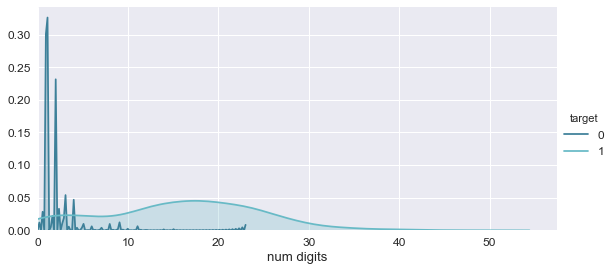

In [9]:
# counting the number of digits per text
def count_digits(df):
    num_digits= sum(char.isdigit() for char in df["text"])
    return num_digits

df["num digits"]= df.apply(count_digits, axis=1)

# visualising the distribution of the number of digits per text
sns.set(font_scale=1.2)
fig= sns.FacetGrid(df, hue="target", size=4, aspect=2, palette="GnBu_d")
fig.map(sns.kdeplot, "num digits", shade=True)
fig.set(xlim=0)
fig.add_legend(fontsize=12)

In [10]:
# calculating the average number of digits per spam/non-spam text
spam_avg= df[df["target"]==1]["num digits"].mean()
non_spam_avg= df[df["target"]==0]["num digits"].mean()
print("Average number of digits per spam text {:.2f} vs. non-spam text {:.2f}.".format(spam_avg, non_spam_avg))

Average number of digits per spam text 15.76 vs. non-spam text 0.30.


The above plot indicates that the vast majority of non-spam text messages has 0 to 4 digits. On the contrary, spam messages contain multiple numbers. On average, they include 15.8 digits per text (0.3 digits per non-spam text).

We have seen that the length of a text and the number of digits it contains are indicative of spam. Feeding these new features to our model can drastically improve its performance.

----
## Classification using CountVectorizer
CountVectorizer is a popular Scikit-learn tool that converts a text corpus to a matrix of token counts. Before using it, let's split the dataset into a training set and a test set.

In [11]:
# splitting the dataset
X_train, X_test, y_train, y_test= train_test_split(df["text"], df["target"], random_state=0)

In [12]:
# CountVectorizer
vect= CountVectorizer().fit(X_train)
X_train_vect= vect.transform(X_train)
X_test_vect= vect.transform(X_test)

We can now add our generated features to the vectorized X_train and X_test.

In [13]:
# function to add new features to the training data
def add_feature(X, new_feature):
    return hstack([X, csr_matrix(new_feature).T], "csr")

# adding features to X_train_vect and X_test_vect
X_train_vect2= add_feature(X_train_vect, X_train.str.len())
X_train_vect_final= add_feature(X_train_vect2, X_train.str.count(r'\d'))
X_test_vect2= add_feature(X_test_vect, X_test.str.len())
X_test_vect_final= add_feature(X_test_vect2, X_test.str.count(r'\d'))

Our data is ready to be fed to different classifiers. For each model, we will compute the ROC AUC score.

In [14]:
# Logistic Regression with default parameters
logreg= LogisticRegression().fit(X_train_vect_final, y_train)
pred_logreg= logreg.predict(X_test_vect_final)
print("Logistic Regression ROC AUC score: ", roc_auc_score(y_test, pred_logreg))

# Multinomial Naive Bayes with default parameters
mnb= MultinomialNB().fit(X_train_vect_final, y_train)
pred_mnb= mnb.predict(X_test_vect_final)
print("Multinomial Naive Bayes ROC AUC score: ", roc_auc_score(y_test, pred_mnb))

# Support Vector Classifier with default parameters
svc= SVC().fit(X_train_vect_final, y_train)
pred_svc= svc.predict(X_test_vect_final)
print("Support Vector Classifier ROC AUC score: ", roc_auc_score(y_test, pred_svc))

Logistic Regression ROC AUC score:  0.959002512605
Multinomial Naive Bayes ROC AUC score:  0.967064495866
Support Vector Classifier ROC AUC score:  0.89343072509


The best ROC AUC score we obtain when using CountVectorizer is 96.7%, with the Multinomial Naive Bayes model. Note that, since we have used default parameters for each model, there is room for improvement. We will compare these results with the ones obtained with TfidfVectorizer and tune the parameters of the best candidate model.

----
## Classification using TfidfVectorizer
TF-IDF stands for Term Frequency - Inverse Document Frequency. It is more sophisticated than CountVectorizer because after having counted how often words appear within a document, it also normalises the counts. In other words, this approach takes word 'importance' into account by scaling according to frequency.

In [15]:
# TfidfVectorizer
tfidf= TfidfVectorizer().fit(X_train)
X_train_tfidf= tfidf.transform(X_train)
X_test_tfidf= tfidf.transform(X_test)

In [16]:
# adding features to X_train_vect and X_test_vect
X_train_tfidf2= add_feature(X_train_tfidf, X_train.str.len())
X_train_tfidf_final= add_feature(X_train_tfidf2, X_train.str.count(r'\d'))
X_test_tfidf2= add_feature(X_test_tfidf, X_test.str.len())
X_test_tfidf_final= add_feature(X_test_tfidf2, X_test.str.count(r'\d'))

# Logistic Regression
logreg= LogisticRegression().fit(X_train_tfidf_final, y_train)
pred_logreg= logreg.predict(X_test_tfidf_final)
print("Logistic Regression ROC AUC score: ", roc_auc_score(y_test, pred_logreg))

# Multinomial Naive Bayes
mnb= MultinomialNB().fit(X_train_tfidf_final, y_train)
pred_mnb= mnb.predict(X_test_tfidf_final)
print("Multinomial Naive Bayes ROC AUC score: ", roc_auc_score(y_test, pred_mnb))

# Support Vector Classifier
svc= SVC().fit(X_train_tfidf_final, y_train)
pred_svc= svc.predict(X_test_tfidf_final)
print("Support Vector Classifier ROC AUC score: ", roc_auc_score(y_test, pred_svc))

Logistic Regression ROC AUC score:  0.929829550278
Multinomial Naive Bayes ROC AUC score:  0.918034735073
Support Vector Classifier ROC AUC score:  0.89343072509


The ROC AUC score obtained after having used TfidfVectorizer are slightly lower than the ones we got with CountVectorizer. The best candidate model seems to be a Multinomial Naive Bayes model combined with CountVectorizer. Let's try and improve its performance by tuning its parameters.

----
## Final model tuning
A convenient way to perform parameter tuning is to use GridSearchCV from Scikit-learn.

In [17]:
# parameter tuning with GridSearchCV
model= MultinomialNB()
grid_values= {"alpha": [0.01, 0.1, 1.0]}
grid= GridSearchCV(model, param_grid=grid_values, scoring="roc_auc")
grid.fit(X_train_vect_final, y_train)
print("Best ROC AUC score: ", grid.best_score_)
print("Model: ", grid.best_estimator_)

Best ROC AUC score:  0.981917939921
Model:  MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


Using $\alpha$=0.1 significantly improves our model's performance, bringing its ROC AUC score to 98.2%. We can plot the ROC curve to have a look at it.

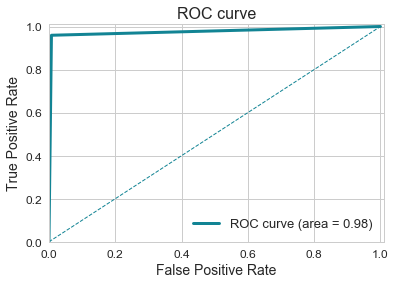

In [18]:
# visualising the ROC curve
sns.set_style("whitegrid")
false_pos_rate, true_pos_rate, _= roc_curve(y_test, grid.predict(X_test_vect_final))
roc_auc= auc(false_pos_rate, true_pos_rate)
plt.plot(false_pos_rate, true_pos_rate, lw=3, color="#128494", label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color="#128494", lw=1, linestyle='--')

----
## Conclusion


In this Natural Language Processing project, we compared different approaches to predict spam text messages. 

We started by preprocessing the messages: making text lowercase, removing punctuation and stop-words, stemming words. We then generated new features from the text messages. We compared the effect of using CountVectorizer vs. TfidfVectorizer, trained several models and selected the best candidate model for optimisation using GridSearchCV.

The best performance was obtained with a Multinomial Naive Bayes model with $\alpha$=0.1 and a CountVectorizer approach, corresponding to a ROC AUC score of 98.2%.